In [16]:
# SHASHANK KATHAVATE
# 2021530332
# ARTIFICIAL INTELLIGENCE - CS6364

The code can be run on GPU or CPU, however the cpu execution take longer. If there is no GPU available please use the same coed on google colab with the GPU enabled. The code requires the files "fashion-mnist_train.csv" and "fashion-mnist_test.csv" in the same directory to run. The outputs will be displayed on the jupyter notebook.

In [17]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d,Tanh,Softmax
from torch.optim import Adam


In [18]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
print(train.shape,test.shape)

                                            

(60000, 785) (10000, 785)


In [19]:
fMNISTTrain = list(train.values)
labelTrainList = []
imageTrainList = []
for i in fMNISTTrain:
    labelTrainList.append(i[0])
    imageTrainList.append(i[1:])
labelsTrain = np.asarray(labelTrainList)
imagesTrain = np.asarray(imageTrainList).reshape(-1, 28, 28).astype('float32')

fMNISTTest = list(test.values)
labelTestList = []
imageTestList = []
for i in fMNISTTest:
    labelTestList.append(i[0])
    imageTestList.append(i[1:])
labelsTest = np.asarray(labelTestList)
imagesTest = np.asarray(imageTestList).reshape(-1, 28, 28).astype('float32')

In [20]:
xTrainSet = imagesTrain
yTrainSet = labelsTrain

xTestSe = imagesTest
yTestSet = labelsTest

print(xTrainSet.shape,yTrainSet.shape)
print(xTestSe.shape,yTestSet.shape)

(60000, 28, 28) (60000,)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x147e00850>)

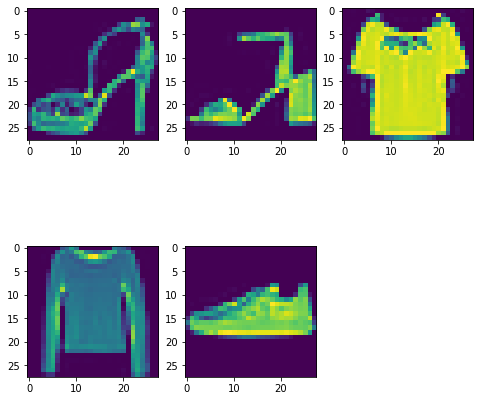

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTrainSet[30])
plt.subplot(232), plt.imshow(xTrainSet[60])
plt.subplot(233), plt.imshow(xTrainSet[90])
plt.subplot(234), plt.imshow(xTrainSet[120])
plt.subplot(235), plt.imshow(xTrainSet[150])

In [22]:
xTrain,xValidation,yTrain,yValidation = train_test_split(xTrainSet,yTrainSet,test_size=0.1)

xTrain = xTrain.reshape(54000,1,28,28)
xValidation = xValidation.reshape(6000,1,28,28)
xValidation = torch.from_numpy(xValidation)
xTrain = torch.from_numpy(xTrain)
yTrain = yTrain.astype(int)
yValidation = yValidation.astype(int)
yTrain = torch.from_numpy(yTrain)
yValidation = torch.from_numpy(yValidation)
print(xTrain.shape,yTrain.shape,xValidation.shape,yValidation.shape)

torch.Size([54000, 1, 28, 28]) torch.Size([54000]) torch.Size([6000, 1, 28, 28]) torch.Size([6000])


In [23]:
class LeNet5(Module):

    def __init__(self):
        super().__init__()

        self.layer1 = Sequential(
            Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(6),
            Tanh(),
            MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = Sequential(
            Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(16),
            Tanh(),
            MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = Linear(256, 120)
        self.tanh = Tanh()
        self.fc1 = Linear(120, 84)
        self.tanh1 = Tanh()
        self.fc2 = Linear(84, 10)
        self.softmax = Softmax(dim=1)
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = self.tanh(x)
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [24]:
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
lossFunc = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    lossFunc = lossFunc.cuda()
    
print(model)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=120, bias=True)
  (tanh): Tanh()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (tanh1): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [25]:
trainLossList = []
validationLossList = []

def trainData(epoch):
    model.train()
    xTrainData,yTrainData = Variable(xTrain), Variable(yTrain)
    xValidationData, yValidationData = Variable(xValidation),Variable(yValidation)

    if torch.cuda.is_available():
        xTrainData = xTrainData.cuda()
        yTrainData = yTrainData.cuda()
        xValidationData = xValidationData.cuda()
        yValidationData =yValidationData.cuda()
    else:
        print("NO GPU")
    optimizer.zero_grad()

    yPredTrain = model(xTrainData)
    ypredValidation = model(xValidationData)

    trainLoss = lossFunc(yPredTrain,yTrainData)
    validationLoss = lossFunc(ypredValidation,yValidationData)
    trainLossList.append(trainLoss.cpu().detach().numpy())
    validationLossList.append(validationLoss.cpu().detach().numpy())

    trainLoss.backward()
    optimizer.step()
    trainLossSum = trainLoss.item()
    if epoch%2 == 0:
        print('Epoch: ',epoch+1,'\t','loss: ',validationLoss)



In [26]:
totalEpochs = 10

for epoch in range(totalEpochs):
    trainData(epoch)


NO GPU
Epoch:  1 	 loss:  tensor(2.3013, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  3 	 loss:  tensor(2.1780, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  5 	 loss:  tensor(2.0107, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  7 	 loss:  tensor(1.9576, grad_fn=<NllLossBackward0>)
NO GPU
NO GPU
Epoch:  9 	 loss:  tensor(1.9295, grad_fn=<NllLossBackward0>)
NO GPU


<function matplotlib.pyplot.show(close=None, block=None)>

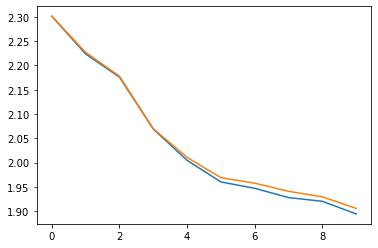

In [27]:
#plotting the losses
plt.plot(trainLossList,label = 'Training')
plt.plot(validationLossList,label='Validation')
plt.show

In [28]:
#Accuracy
def calcAccuracy(x,y):
    if torch.cuda.is_available():
        with torch.no_grad():
            yTrainPred = model(x.cuda())
            softmax = torch.exp(yTrainPred).cpu()
    
    else:
        yTrainPred = model(x)
        softmax = torch.exp(yTrainPred.detach())
        
    
    probability = list(softmax.numpy())
    predictions = np.argmax(probability, axis=1)
    # accuracy on training set
    return accuracy_score(y, predictions)


trainAccuracy = calcAccuracy(xTrain,yTrain)
validationAccuracy = calcAccuracy(xValidation,yValidation)

print("Train Accuracy= ",trainAccuracy)
print("Validation Accuracy= ",validationAccuracy)

Train Accuracy=  0.5906851851851852
Validation Accuracy=  0.5785


In [32]:
xTestSet = xTestSe.reshape(10000,1,28,28)
xTestSet = torch.from_numpy(xTestSet)
print(xTestSet.shape)

torch.Size([10000, 1, 28, 28])


['T-Shirt/top', 'Trouser', 'Sandal', 'Coat', 'Dress']


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x16b3e97b0>)

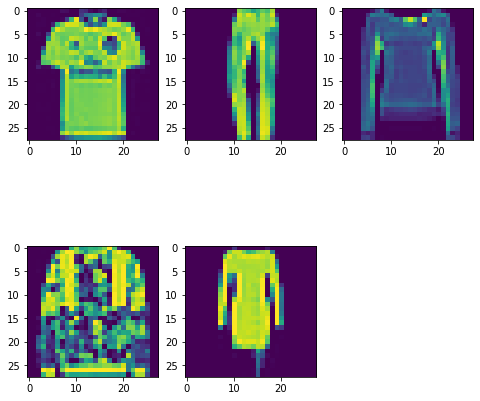

In [33]:
#Test set predicitons

if torch.cuda.is_available():
    with torch.no_grad():
        yTestPred = model(xTestSet.cuda())
        softmax = torch.exp(yTestPred).cpu()
else:
    yTestPred = model(xTestSet)
    softmax = torch.exp(yTestPred.detach())
    
probability = list(softmax.numpy())
predictions = np.argmax(probability, axis=1)
labelDict = {
    0:"T-Shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle Boot"
}
#Results for the 10000 test data images. The above dictionary represents the classification label for the data.
predictions = [labelDict[i] for i in predictions]
#First 5 Predictions
print(predictions[:5])
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTestSe[0])
plt.subplot(232), plt.imshow(xTestSe[1])
plt.subplot(233), plt.imshow(xTestSe[2])
plt.subplot(234), plt.imshow(xTestSe[3])
plt.subplot(235), plt.imshow(xTestSe[4])

# The Above show the first 5 predictions of the test data set. It may be seen that they have an accuracy of almost 80%. With the prediction on image 3 being incorrect.